# Neural Posterior Estimation for simulation-based inference

# NPE, NLE, or NRE?

- We decided to have a dedicated session of Neural **Posterior** estimation (NPE) and then have a follow-up on Neural **Likelihood** and Neural **Ratio** estimation (NLE and NRE).

- By no means do we want to say that NPE is better than NLE and NRE.

- We will have a session on comparing the methods tomorrow.

Lastly, each of these three methods has a `sequential` option (strictly optional!). We will discuss this later today. The sequential methods are referred to as **S**NPE, **S**NLE, **S**NRE, but we ofter use these acronyms also for the non-sequential versions for simplicity.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
from mdn import MultivariateGaussianMDN, mog_log_prob, mog_sample

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi
from torch.utils import data
import numpy as np
from torch import tensor, ones, zeros, eye
from scipy.signal import argrelextrema
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
from torch.distributions import Normal
import sdeint
_ = torch.manual_seed(0)

In [6]:
from numpy import *
from scipy import integrate

# The main idea

In Neural Posterior Estimation (NPE) want to use conditional density estimation to learn the posterior $p(\theta | x)$.

As a first step, we have to generate a dataset that follows the joint density $p(\theta, x)$.

We can obtain this by sampling from $p(\theta)$ (the prior) and then sampling the likelihood $p(x | \theta)$ (i.e. simulating). The resulting $(\theta, x)$ pairs follow $p(\theta, x) = p(\theta)p(x|\theta)$.

In [7]:
def simulator(theta):
    return theta*2.0 + torch.sin(theta*6) + torch.randn(theta.shape) * 0.3

prior = BoxUniform([0.0], [1.0,])
theta = prior.sample((10_000,))

x = simulator(theta)

In [8]:
num_bins = 100
mat, _, _ = np.histogram2d(x.numpy()[:, 0], theta.numpy()[:, 0], bins=num_bins, range=[[-1, 3], [0, 1]])

In [9]:
theta_demo = 0.2
theta_ind = int(num_bins * theta_demo)

x_demo = 0.4
x_ind = int(num_bins*((x_demo + 1) / 4))

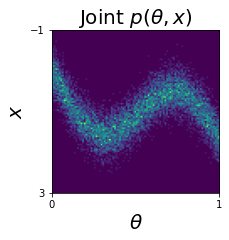

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat, extent=[0, 1, 3, -1], aspect='auto')
ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
ax.set_title(r"Joint $p(\theta, x)$", fontsize=20)
plt.savefig("figures/2_2_snpe/simple_joint.png", dpi=200, bbox_inches="tight")

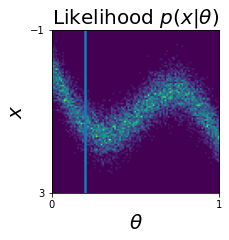

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat, extent=[0, 1, 3, -1], aspect='auto')
ax.plot([theta_demo, theta_demo], [-1, 3], linewidth=2.5)
ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
ax.set_title(r"Likelihood $p(x | \theta)$", fontsize=20)
plt.savefig("figures/2_2_snpe/simple_joint_NLE.png", dpi=200, bbox_inches="tight")

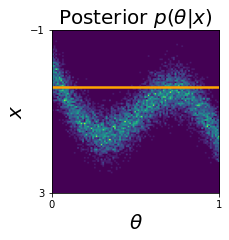

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat, extent=[0, 1, 3, -1], aspect='auto')
ax.plot([0, 1], [x_demo, x_demo], c="orange", linewidth=2.5)
ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
ax.set_title(r"Posterior $p(\theta | x)$", fontsize=20)
plt.savefig("figures/2_2_snpe/simple_joint_NPE.png", dpi=200, bbox_inches="tight")

<img src="figures/2_2_snpe/simple_joint_all.png" alt="drawing" width="1500"/>

### Neural Posterior estimation: recipe

- sample parameters $\theta$ from prior $p(\theta)$
- run each of these parameters through the (stochastic) simulator to obtain $x \sim p(x | \theta)$
- train a conditional density estimator on these data to learn $p(\theta | x)$:

<img src="figures/2_2_snpe/npe_illustration.png" alt="drawing" width="1500"/>

# Time to see this in action...

# Define a simulator: Lotka-Volterra

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$\frac{du}{dt} = au - buv + \epsilon$  
$\frac{dv}{dt} = -cv + dbuv + \epsilon$

```
| a   | prey reproduction rate |
| b   | prey death rate per predator |
| c   | predator death rate (if no prey) |
| d   | predators born per prey |
```
```
| u   | prey / rabbits
| v   | predator / foxes
```
$\epsilon$ is Gaussian noise.

Code taken from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

# Let's have a look at the output:

Let's simulate this stochastic differential equation for $(a, b, c, d)$  = (1.0, 0.1, 1.5, 0.75):

<img src="figures/2_2_snpe/xo_lotka.png" alt="drawing" width="900"/>


Let's assume that we observe the evolution of the population and we want to infer the parameters $a$ and $b$ (assume that $c$ and $d$ are known).

### The SDE in code

In [13]:
t = linspace(0, 15, 1000)      # time
X0 = array([10.0, 5.0])        # initials conditions: 10 rabbits and 5 foxes

In [14]:
def run_model(theta):
    a = theta[0]
    b = theta[1]
    c = 1.5
    d = 0.75
    
    def dX_dt(X, t):
        return array([ a*X[0] -   b*X[0]*X[1] ,
                      -c*X[1] + d*b*X[0]*X[1] ])
    def dW(x, t):
        return 0.7 * np.eye(2)  # Gaussian noise

    X = sdeint.itoint(dX_dt, dW, X0, t)
    return X

In [15]:
theta = [1.0, 0.1]  # parameters (a, b)
X = run_model(theta)

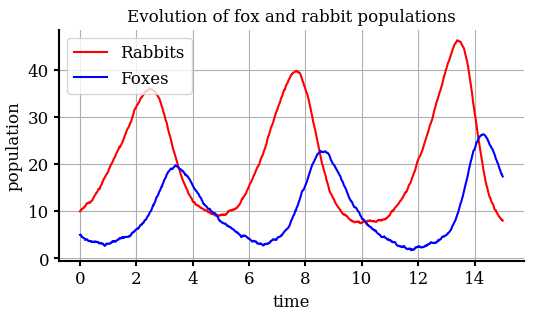

In [16]:
with mpl.rc_context(fname=".matplotlibrc"):
    rabbits, foxes = X.T
    f1 = plt.subplots(1, 1, figsize=(6, 3))
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    plt.title('Evolution of fox and rabbit populations')
    plt.savefig("figures/2_2_snpe/xo_lotka.png", dpi=200, bbox_inches="tight")

# Exercise 1: Get a feeling for the simulator.

Run the simulator for different parameter values of $(a, b)$. You can vary $a$ in the range [0.5, 3.5] and $b$ in range [0.0, 0.3]. Look at the traces for a couple of different combinations of $a$ an $b$.

In [17]:
theta = [3.3, 0.29]  # parameters (a, b)
X = run_model(theta)

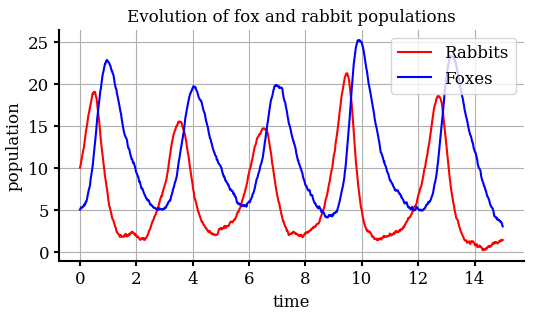

In [18]:
with mpl.rc_context(fname=".matplotlibrc"):
    rabbits, foxes = X.T
    f1 = plt.subplots(1, 1, figsize=(6, 3))
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    plt.title('Evolution of fox and rabbit populations')
    plt.savefig("figures/2_2_snpe/xo_lotka_2.png", dpi=200, bbox_inches="tight")

# Summary statistics

In principle, we can run NPE on the raw trace (more on that later). However, it is often preferable to define summary statistics that are of interest and try reproducing only those. Here, we use the means, variances, autocorrelations, and cross-correlation of the two traces.

In [19]:
def summstats(trace):
    rabbits_mean = [np.mean(trace[:, 0])]
    foxes_mean = [np.mean(trace[:, 1])]
    rabbits_variance = [np.var(trace[:, 0])]
    foxes_variance = [np.var(trace[:, 1])]
    autocorr_rabbits1 = [np.correlate(trace[:, 0], trace[:, 0], "full")[100]]
    autocorr_rabbits2 = [np.correlate(trace[:, 0], trace[:, 0], "full")[200]]
    autocorr_foxes1 = [np.correlate(trace[:, 1], trace[:, 1], "full")[100]]
    autocorr_foxes2 = [np.correlate(trace[:, 1], trace[:, 1], "full")[200]]
    cross_corr = np.correlate(trace[:, 0], trace[:, 1])
    
    summ_stats = np.concatenate(
        [
            rabbits_mean, foxes_mean, rabbits_variance, foxes_variance, 
            autocorr_rabbits1, autocorr_rabbits2, 
            autocorr_foxes1, autocorr_foxes2, cross_corr
        ]
    )
    return summ_stats

# Define a prior

We then have to define a prior (a "first guess of plausible values"). Here, we pick a uniform distribution within some bounds of reasonable values.

In [20]:
lower_bound = [0.5, 0.0]
upper_bound = [3.5, 0.5]
prior = BoxUniform(lower_bound, upper_bound)

# Generate simulated data
We will run 500 simulations that will be used to train the conditional density estimator.

In [21]:
N = 50  # number of simulations

thetas = prior.sample((N,))
xs = []
for theta in thetas:
    trace = run_model(theta)
    summ_stats = summstats(trace)
    xs.append(summ_stats)
xs = np.stack(xs)

To save the time of simulating: We have already simulated 5000 traces with different parameters.

In [22]:
num_simulations = 5000
thetas = np.load("lotka_volterra_dataset/theta_5000.npy")[:num_simulations]
xs = np.load("lotka_volterra_dataset/x_5000.npy")[:num_simulations]

# Data pre-processing

Let's inspect our simulation results. One thing we will realize is that some simulations produce `NaN`:

In [23]:
print("The summary statistics of the 1st simulation: ", xs[0])
print("The summary statistics of the 8th simulation: ", xs[7])

The summary statistics of the 1st simulation:  [7.86337536e+00 3.34961689e+00 3.25892682e+01 9.24829249e+00
 1.30754309e+03 9.73644607e+03 1.80100346e+03 5.30209935e+03
 2.57441177e+04]
The summary statistics of the 8th simulation:  [nan nan nan nan nan nan nan nan nan]


In (Sequential) Neural **Posterior** estimation (SNPE), we can simply exclude those simulations from training for which at least one summary feature is `NaN`:

In [24]:
contains_no_nan = np.invert(np.any(np.isnan(xs), axis=1))
thetas_train = thetas[contains_no_nan]
xs_train = xs[contains_no_nan]

We also exclude very large values. For some simulations, the SDE can produce values of up to $10^{45}$ for the crosscorrelation (the other simulations are around $10^4$). These large values break neural network training.

In [25]:
print("A regular simulation output for crosscorrelation:     ", xs[0, -1])
print("Some gigantic simulation output for crosscorrelation: ", xs[2854, -1])

A regular simulation output for crosscorrelation:      25744.11774052111
Some gigantic simulation output for crosscorrelation:  -2.918668084054304e+45


In [26]:
contains_no_inf = np.invert(np.any(xs_train < -1e6, axis=1))
thetas_train = thetas_train[contains_no_inf]
xs_train = xs_train[contains_no_inf]

contains_no_inf = np.invert(np.any(xs_train > 1e6, axis=1))
thetas_train = thetas_train[contains_no_inf]
xs_train = xs_train[contains_no_inf]

We also have to standardize (i.e. z-score) the data:

In [27]:
thetas_torch = torch.as_tensor(thetas_train, dtype=torch.float32)
xs_torch = torch.as_tensor(xs_train, dtype=torch.float32)

xs_mean = torch.mean(xs_torch, dim=0)
xs_std = torch.std(xs_torch, dim=0)
xs_zscored = (xs_torch - xs_mean) / xs_std

theta_mean = torch.mean(thetas_torch, dim=0)
theta_std = torch.std(thetas_torch, dim=0)
theta_zscored = (thetas_torch - theta_mean) / theta_std

# Exercise 1: Train neural network to learn $p(\theta | x)$

We now use a Mixture density network (as in the previous tutorial!) to learn the conditional density $p(\theta | x)$ (=the posterior).

In [28]:
_ = torch.manual_seed(0)

In [29]:
dataset = data.TensorDataset(theta_zscored, xs_zscored)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=2,
    hidden_net=nn.Sequential(
        nn.Linear(9, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
    ),
    num_components=3,
    hidden_features=10,
)

opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(100):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        weights_of_gaussians, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, weights_of_gaussians, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

# Define an observation

We will now define an **observation** $x_o$, i.e. the data that we want for which we want to infer the posterior $p(\theta|x_o)$. In real problems, this will be an experimentally measured trace and we will not know the ground truth parameter.

In [30]:
_ = torch.manual_seed(0)

In [31]:
gt = [1.0, 0.1]  # not known in real problems.
xo_trace = run_model(gt)
xo = summstats(xo_trace)
xo = torch.as_tensor(xo, dtype=torch.float32)

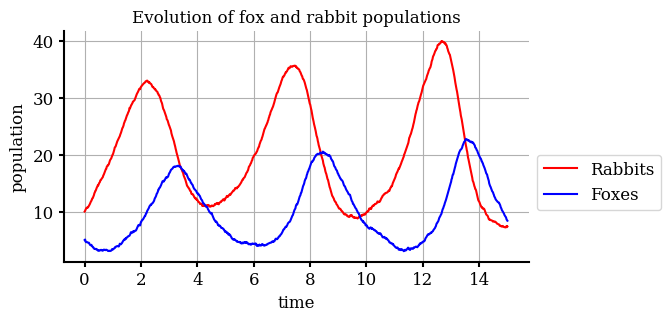

In [32]:
# Same as above, therefore not saved here.
with mpl.rc_context(fname=".matplotlibrc"):
    rabbits, foxes = xo_trace.T
    f1 = plt.subplots(1, 1, figsize=(6, 3))
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best', fontsize=12.0, bbox_to_anchor=(1.0, 0.5))
    plt.xlabel('time', fontsize=12.0)
    plt.ylabel('population', fontsize=12.0)
    plt.title('Evolution of fox and rabbit populations', fontsize=12.0)
    # Same as above, therefore not saved here.

Because we trained the neural network on z-scored data, we also have to z-score the summary stats of $x_o$:

In [33]:
xo_zscored = (xo - xs_mean) / xs_std
xo_torch = torch.as_tensor(xo_zscored, dtype=torch.float32).unsqueeze(0)

### Draw samples from posterior

In [34]:
n = 500
weigths_of_gaussians, means, variances = mdn.get_mixture_components(xo_torch)

samples = []
for _ in range(n):
    samples.append(mog_sample(weigths_of_gaussians, means, variances))
    
samples = torch.cat(samples).detach()
samples = samples * theta_std + theta_mean  # de-standardize the parameters

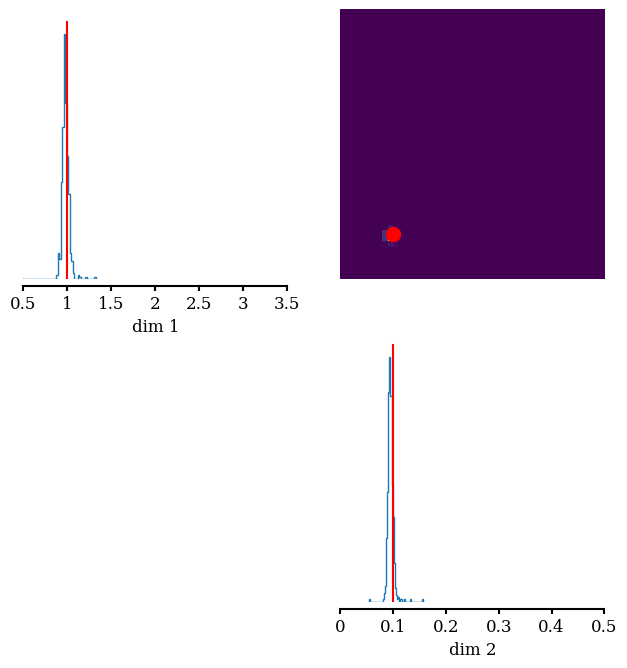

In [35]:
with mpl.rc_context(fname=".matplotlibrc"):
    _ = pairplot(samples, limits=[[0.5, 3.5], [0.0, 0.5]], points=[gt], figsize=(7.5, 7.5), points_colors="r")

# How to evaluate that this is correct?

More on this later! But a quick check are **Posterior predictive checks**. We draw parameters from the posterior, simulate them, and inspect whether the resulting traces match $x_o$.

In [36]:
gt_simulation = run_model(gt)
rabbits_gt, foxes_gt = gt_simulation.T

posterior_simulation = [run_model(samples[i]).T for i in range(10)]
rabbits_sim = [pair[0] for pair in posterior_simulation]
foxes_sim = [pair[1] for pair in posterior_simulation]

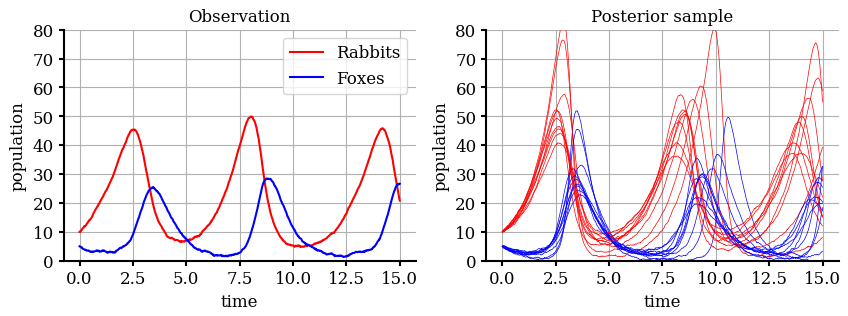

In [37]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(t, rabbits_gt, 'r-', label='Rabbits')
    ax[0].plot(t, foxes_gt  , 'b-', label='Foxes')
    ax[0].grid()
    ax[0].legend(loc='upper right', fontsize=12.)
    ax[0].set_xlabel('time', fontsize=12.)
    ax[0].set_ylabel('population', fontsize=12.)
    ax[0].set_title("Observation", fontsize=12.)
    ax[0].set_ylim([0, 80])

    for i in range(10):
        ax[1].plot(t, rabbits_sim[i], 'r-', label='Rabbits', lw=0.5)
        ax[1].plot(t, foxes_sim[i], 'b-', label='Foxes', lw=0.5)
    ax[1].grid()
    ax[1].set_xlabel('time', fontsize=12.)
    ax[1].set_ylabel('population', fontsize=12.)
    ax[1].set_title("Posterior sample", fontsize=12.)
    ax[1].set_ylim([0, 80])

    plt.savefig("figures/2_2_snpe/post_predictives.png", dpi=200, bbox_inches="tight")

# Exercise 2: Try different number of training samples

- first, familiarize yourself with the code above and make sure you understand what's going on.
- Then, go back to the cell in which we loaded the presimulated data:
```python
num_simulations = 5000
thetas = np.load("lotka_volterra_dataset/theta_5000.npy")[:num_simulations]
xs = np.load("lotka_volterra_dataset/x_5000.npy")[:num_simulations]
```
- try training the neural network and evaluating the posterior with fewer simulations. What do you observe as you go to around $500$ (or even fewer) simulations?

<img src="figures/2_2_snpe/posterior_bad.png" alt="drawing" width="500"/>
<img src="figures/2_2_snpe/post_predictives_bad.png" alt="drawing" width="1000"/>

# Congrats, you understood the basics of NPE!

Let's move on to some cool features...

# Amortization

One of the cool features of NPE is that the posterior is **amortized**. This means that, after the simulations are done and the network is trained, one can quickly obtain the posterior for any observation $x_o$ (a single forward pass through the neural network)

# Exercise 3: Test amortization for a few different $x_o$

Use the code cells below to test amortization. In other words: change the parameters used to generate observed data (`gt2 = ...`) and inspect whether the posterior samples match the observed data.

In [38]:
_ = torch.manual_seed(0)

In [39]:
gt2 = [3.0, 0.2]
xo2_trace = run_model(gt2)
xo2 = summstats(xo2_trace)
xo2 = torch.as_tensor([xo2], dtype=torch.float32)
xo_torch2 = (xo2 - xs_mean) / xs_std

In [40]:
weigths_of_gaussians, means, variances = mdn.get_mixture_components(xo_torch2)

samples = []
for _ in range(n):
    samples.append(mog_sample(weigths_of_gaussians, means, variances)) 

samples = torch.cat(samples).detach()
samples = samples * theta_std + theta_mean

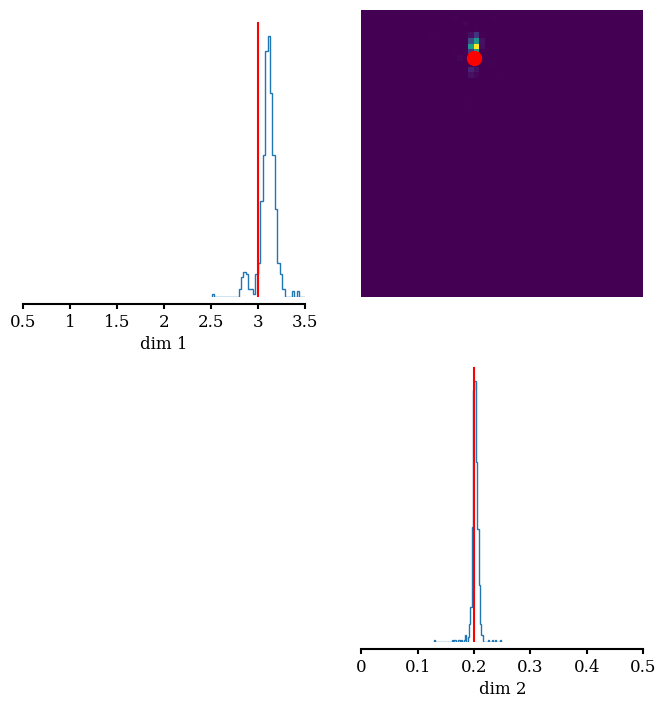

In [41]:
with mpl.rc_context(fname=".matplotlibrc"):
    _ = pairplot(samples, limits=np.asarray([lower_bound, upper_bound]).T, points=[gt2], figsize=(8, 8), points_colors="r")

In [42]:
gt_simulation = run_model(gt2)
rabbits_gt, foxes_gt = gt_simulation.T

posterior_simulation = [run_model(samples[i]).T for i in range(10)]
rabbits_sim = [pair[0] for pair in posterior_simulation]
foxes_sim = [pair[1] for pair in posterior_simulation]

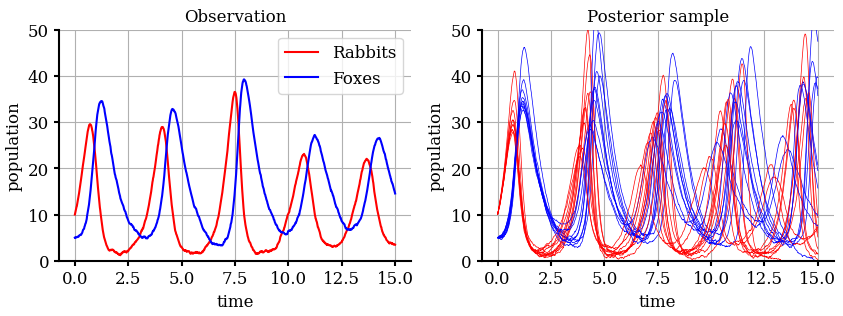

In [43]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(t, rabbits_gt, 'r-', label='Rabbits')
    ax[0].plot(t, foxes_gt, 'b-', label='Foxes')
    ax[0].grid()
    ax[0].legend(loc='upper right')
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('population')
    ax[0].set_title("Observation")
    ax[0].set_ylim([0, 50])

    posterior_simulation = run_model(samples[0])
    for i in range(10):
        ax[1].plot(t, rabbits_sim[i], 'r-', label='Rabbits', lw=0.5)
        ax[1].plot(t, foxes_sim[i], 'b-', label='Foxes', lw=0.5)
    ax[1].grid()
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('population')
    ax[1].set_title("Posterior sample")
    ax[1].set_ylim([0, 50])
    plt.savefig("figures/2_2_snpe/post_predictives2.png", dpi=200, bbox_inches="tight")

# Embedding network

So far, we used summary statistics of the raw trace (i.e. the mean, variance, cross-correlation, etc.).

In some cases, you might not want to (or can not) define summary statistics. What to do then?

We can learn summary statistics! One can pass the simulated data $x$ through **any** neural network before regressing on the Mixture Parameters (e.g. CNN, LSTM, GNN,...)

<img src="figures/2_2_snpe/cnn.png" alt="drawing" width="1500"/>

The network will automatically extract relevant features!

In [44]:
dataset = data.TensorDataset(theta_zscored, xs_zscored)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=2,
    hidden_net= # <--here goes the CNN, LSTM, GNN,..
    num_components=1,
    hidden_features=10,
)

opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(500):
    if e % 100 == 0:
        print("Epoch: ", e) 
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        logits, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, logits, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

SyntaxError: invalid syntax (2826463797.py, line 8)

### Should I use an embedding net?

Advantages:
- No need for hand-selected features
- possible insights into which features are learned by the CNN, LSTM,...

Disadvantages:
- Probably more training data needed to learn useful features

My opinion:
- If you can extract useful summary statistics (or you really care about them!), do inference using summary statistics
- Only use the embedding network if necessary.

# Sequential Neural Posterior Estimation (SNPE)

### Problem
When sampling from the prior, many simulations might produce results that are entirely different from the observed data (e.g. in Lotka volterra, many parameter combinations might not lead to oscillation). Often, these simulations are less informatative of the posterior distribution $p(\theta|x_o)$. We thus would prefer to sample from parameter regions that produce data close to $x_o$.


### Solution
In "multi-round" inference, we start by sampling from the prior, simulate, train a neural network, and obtain $p(\theta|x_o)$. We then sample from the posterior, simulate, and re-train the neural network. This process can be obtained for several "rounds" until the posterior estimate is good enough.

Say we have a single observation $x_o$ for which we want to find the posterior $p(\theta|x_o)$.

<img src="figures/2_2_snpe/snpe.png" alt="drawing" width="1000"/>

Drawing by JM Lueckmann

### The central problem of multi-round inference

When drawing parameters from the prior and simulating them, we obtain $(\theta, x)$ from the joint distribution $p(\theta, x) \propto p(\theta) p(x|\theta)$.

In [45]:
def implicit_likelihood(theta):
    return theta*2.0 + torch.sin(theta*6) + torch.randn(theta.shape) * 0.3

prior = BoxUniform([0.0], [1.0,])
theta = prior.sample((1_000_000,))

x = implicit_likelihood(theta)

In [46]:
num_bins = 100

In [47]:
mat, _, _ = np.histogram2d(x.numpy()[:, 0], theta.numpy()[:, 0], bins=num_bins, range=[[-1, 3], [0, 1]])

A vertical "cut" through this joint density is the likelihood $p(x | \theta)$, whereas a horizontal cut is the posterior $p(\theta|x)$.

<img src="figures/2_2_snpe/fig1_Bayes.png" alt="drawing" width="600"/>

In [48]:
# Prior was `BoxUniform([0.0], [1.0,])`
proposal = Normal(0.75, 0.4)

proposal_theta = proposal.sample((1_000_000,))

x_proposal = implicit_likelihood(proposal_theta)

In [49]:
mat_prop, _, _ = np.histogram2d(x_proposal.numpy(), proposal_theta.numpy(), bins=num_bins, range=[[-1, 3], [0, 1]])

But: what happens when our simulations are not sampled from the prior? Let's say that, instead of them being sampled from a uniform distribution (the prior), we sample them from the previous posterior (the "proposal).

The data is now sampled from $\overline{p}(\theta, x) \propto \overline{p}(\theta)p(x|\theta)$

<img src="figures/2_2_snpe/demo_prior_proposal.png" alt="drawing" width="1600"/>

Vertical cuts (i.e. the likelihood $p(x|\theta)$) stay the same, whereas horizontal cuts are now different. Thus, when naively training a conditional density estimator on data generated from the proposal, we will not converge to the true posterior distribution anymore.

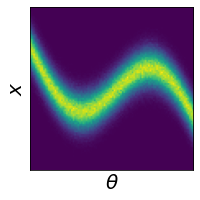

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/2_2_snpe/joint1.png", dpi=200, bbox_inches="tight")

In [51]:
theta_demo = 0.2
theta_ind = int(num_bins * theta_demo)

x_demo = 0.4
x_ind = int(num_bins*((x_demo + 1) / 4))

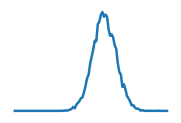

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat[:, theta_ind], linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/2_2_snpe/joint1_aid1.png", dpi=200, bbox_inches="tight")

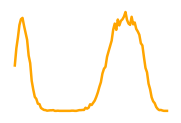

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat[x_ind,:], c="orange", linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/2_2_snpe/joint1_aid2.png", dpi=200, bbox_inches="tight")

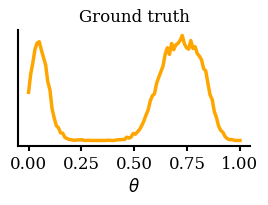

In [54]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    ax.plot(np.linspace(0, 1, 100), mat[x_ind,:], c="orange", linewidth=2.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    _ = ax.set_yticks([])
    ax.set_title("Ground truth")
    ax.set_xlabel(r"$\theta$")
    plt.savefig("figures/2_2_snpe/gt_posterior.png", dpi=200, bbox_inches="tight")

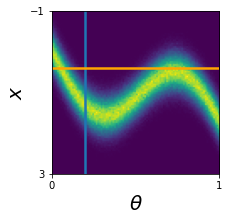

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat, extent=[0, 1, 3, -1], aspect='auto')
ax.plot([theta_demo, theta_demo], [-1, 3], linewidth=2.5)
ax.plot([0, 1], [x_demo, x_demo], c="orange", linewidth=2.5)
ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/2_2_snpe/joint1_lines.png", dpi=200, bbox_inches="tight")

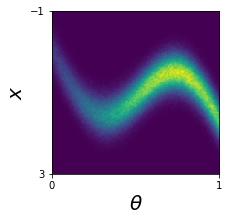

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat_prop, extent=[0, 1, 3, -1], aspect='auto')
ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/2_2_snpe/joint2.png", dpi=200, bbox_inches="tight")

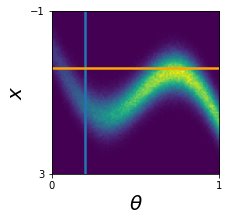

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat_prop, extent=[0, 1, 3, -1], aspect='auto')
ax.plot([theta_demo, theta_demo], [-1, 3], linewidth=2.5)
ax.plot([0, 1], [x_demo, x_demo], c="orange", linewidth=2.5)
ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/2_2_snpe/joint2_lines.png", dpi=200, bbox_inches="tight")

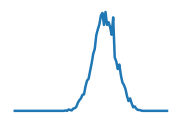

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat_prop[:, theta_ind], linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/2_2_snpe/joint2_aid1.png", dpi=200, bbox_inches="tight")

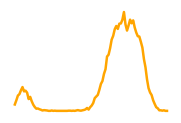

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat_prop[x_ind, :], c="orange", linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/2_2_snpe/joint2_aid2.png", dpi=200, bbox_inches="tight")

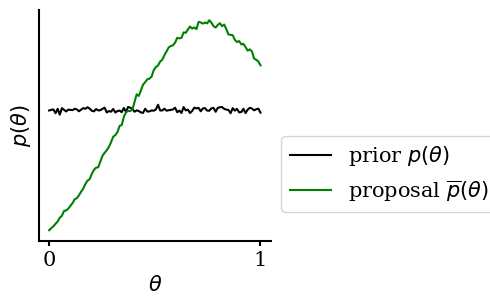

In [60]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    vals, _ = np.histogram(theta[:,0].numpy(), range=[0, 1], bins=100)
    ax.plot(np.linspace(0, 1, num_bins), vals, c="k")
    vals, _ = np.histogram(proposal_theta.numpy(), range=[0, 1], bins=100)
    ax.plot(np.linspace(0, 1, num_bins), vals*1.53, c="green")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(r"$\theta$", fontsize=15.)
    ax.set_ylabel(r"$p(\theta)$", fontsize=15.)
    ax.set_xticks([0,1])
    ax.set_xticklabels([0, 1], fontsize=15.)

    _ = ax.set_yticks([])
    ax.legend([r"prior $p(\theta)$", r"proposal $\overline{p}(\theta)$"], fontsize=15.,bbox_to_anchor=(1.0, 0.5))

    plt.savefig("figures/2_2_snpe/prior_illustration.png", dpi=200, bbox_inches="tight")

# How can we solve this?

Three methods:
- SNPE-A (Papamakarios, Murray, 2016, "Fast $\epsilon$-free Bayesian inference...")
- SNPE-B (Lueckmann, Goncalves, et al. 2017, "Flexible statistical inference...")
- SNPE-C (APT) (Greenberg, Nonnenmacher, Macke, 2019, "Automatic posterior pransformation...")

**Note**: If one does not do multi-round, all methods are identical and simply train with maximal likelihood, just like we have seen so far.

Here, we will focus on SNPE-B.

# SNPE-B

Loss for a single round:

$\mathcal{L} = -\sum_i \log q(\theta_i | x_i)$

Loss of SNPE-B:

$\mathcal{L} = -\sum_i \frac{p(\theta)}{\overline{p}(\theta)} \log q(\theta_i | x_i)$

Let's implement this! We'll start by sampling data not from the prior, but from the proposal, and simulating it:

In [61]:
_ = torch.manual_seed(0)

In [62]:
prior = BoxUniform([0.0], [1.0,])
proposal = Normal(0.75, 0.4)
theta = proposal.sample((5000,)).unsqueeze(1)
x = implicit_likelihood(theta)

We'll then train a mixture density network (same architecture as before) with the adjusted loss:

In [63]:
dataset = data.TensorDataset(theta, x)
train_loader = data.DataLoader(dataset, batch_size=50)
mdn = MultivariateGaussianMDN(
    features=1,
    hidden_net=nn.Sequential(
        nn.Linear(1, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
    ), num_components=5, hidden_features=10)

opt = optim.Adam(mdn.parameters(), lr=0.003)
for e in range(200):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        logits, means, variances = mdn.get_mixture_components(x_batch)
        q_theta = mog_log_prob(theta_batch, logits, means, variances)
        
        # Compute SNPE-B correction: the importance weights
        proposal_prob = torch.exp(proposal.log_prob(theta_batch).squeeze())
        prior_prob = torch.exp(prior.log_prob(theta_batch))
        importance_weights = prior_prob / proposal_prob
        
        loss = -(q_theta * importance_weights).sum()
        loss.backward()
        opt.step()

Let's draw some samples from the posterior for our observation:

In [64]:
xo = torch.tensor([[0.4]])
logits, means, variances = mdn.get_mixture_components(xo)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances)) 

samples = torch.cat(samples).detach()

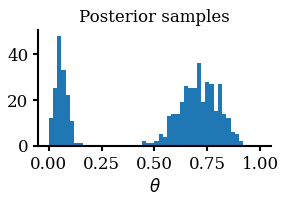

In [66]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    _ = ax.hist(samples.numpy(), bins=50, range=[0, 1])
    ax.set_xlabel(r"$\theta$")
    ax.set_title("Posterior samples")
    plt.savefig("figures/2_2_snpe/snpe_b_posterior.png", dpi=200, bbox_inches="tight")

<img src="figures/2_2_snpe/gt_vs_posterior.png" alt="drawing" width="1500"/>

This looks great! Thanks to the importance weights $\frac{p(\theta)}{\overline{p}(\theta)}$ in the loss we managed to obtain the correct posterior with a different proposal. This allows us to do multi-round SNPE.

# Problems and other versions of SNPE

- if the importance weights get high variance, training can become unstable and fail. 
- Contrary to SNPE-B, both SNPE-A and SNPE-C rely on analytical closed form corrections. This either limits the choice of density estimator (only MDN allowed for SNPE-A and SNPE-C) or leads to other problems (the `atomic` version of SNPE-C allows also for normalizing flows but has other issues ("leakage")).

# Summary

Neural Posterior Estimation (NPE) works as follows:
- sample the prior: $\theta \sim p(\theta)$
- run the simulator for each parameter: $x \sim p(x | \theta)$
- train a conditional density estimator $q(\theta | x)$.
- after training, plug the observed data $x_o$ into the network to obtain the posterior.

Benefits:
- after training, the posterior is **amortized**, i.e. it can rapidly be evaluated for new data (no new simulations or retraining)
- NPE can automatically learn summary statistics with the embedding net

Sequential Neural Posterior Estimation (SNPE) performs inference over multiple rounds.
- This can enhance the simulation efficiency
- But it requires changes to the loss function. The SNPE algorithms differ in how they deal with this.

# Thank you for your attention!